In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import tqdm

In [2]:
TENSORDTYPE = torch.float64

In [3]:
DEVICE = 'cuda:0'

In [4]:
LOGROOTDIR = './solve-pendulum-data/'

if not os.path.exists(LOGROOTDIR):
    os.mkdir(LOGROOTDIR)

In [5]:
# fixed seed for 200 iteration
# seed = 1767     # for model pair (model_1, calc_loss_1)
# seed = 4721     # for model pair (model_5, calc_loss_2)
# seed = 5154     # for model pair (model_2, calc_loss_7)
# seed = 1927     # for model pair (model_3, calc_loss_8)
# seed = 5566     # for model pair (model_1, calc_loss_1_off)
# seed = 4003     # for model pair (model_5, calc_loss_2_off)
# seed = 1886     # for model pair (model_3, calc_loss_8_off)

# fixed seed for 1000 iteration
# seed = 9226     # for model pair (model_1, calc_loss_1)
# seed = ???? 9954  # for model pair (model_5, calc_loss_2)
# seed = 4868     # for model pair (model_3, calc_loss_8)
# seed = 554      # for model pair (model_1, calc_loss_1_off)
# seed = 4886     # for model pair (model_5, calc_loss_2_off)
# seed = 4254     # for model pair (model_3, calc_loss_8_off)

# random seed
seed = random.randint(0, 10000)

# Set the random seed for Python's built-in random module
random.seed(seed)

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed for PyTorch
torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

print(f"Seed: {seed}")

Seed: 8611


All problem-specific functions accpet tensor arguments.

Take $f(t,x,a)$ as an example. We assume its inputs $t, x$ and $a$ are tensors with at least 1 dimension. All dimensions except the last are regarded as batch dimensions and are equivalent in function bodies. The outputs follow this rule too. This means even the time input $t$ and the value $f(t,x,a)$ are both scalar in their definition, we force them to be tensors in shape (1,) too.

We also adopt the sequence-first convention, which is standard in seq2seq training. Most Tensors have shape (T, M, D), where

- T : time axis
- M : batch axis
- D : original dim of this quantity

## Helper Function

In [6]:
def re_cumsum(t, dim):
    r'''torch.cumsum in reverse direction'''
    return t + torch.sum(t, dim, keepdim=True) - torch.cumsum(t, dim)

Solve the stochastic optimal control problem (Lee, J., & Sutton, R. S. (2021), Section 6 Inverted pendulumn simulation examples):
\begin{align}
\operatorname{minimize}\quad& \operatorname{\mathbb{E}}\biggl[g(X_T)+\int_t^Tf(X_\tau,\alpha_\tau)\,d\tau\biggr], \\
\operatorname{subject\ to}\quad& X_s = x + \int_t^s \bar{b}(\tau,X_\tau)\,d\tau +  \int_t^s\sigma(\hat{b}_0\,\alpha_\tau\,d\tau + dW_\tau),
\end{align}
where $x:=(\theta, \dot\theta)$, $g(x)=\theta^2 + 0.01\dot\theta^2$, $f(x,a)=g(x) + \frac{r_0}{2}\|a\|^2$,
$$\bar{b}(t,x) = \begin{bmatrix}
\dot\theta \\ 9.8\sin\theta - 0.01\dot\theta
\end{bmatrix}, \quad
\sigma\hat{b}_0(t,x) = \begin{bmatrix}
0 \\ -\cos\theta
\end{bmatrix}.$$
Choice I: $\sigma=\operatorname{diag}\{\sigma_1, \sigma_2\}$, $\hat{b}_0(t,x) = (0, -\cos\theta/\sigma_2)^\intercal$,
$$\mu(t,x,z) = \operatorname*{arginf}_{a\in [a_\textrm{max},a_\textrm{min}]} - az_2\cos\theta/\sigma_2 + \frac{r_0}{2}a^2
=\mathtt{clamp}(\frac{z_2\cos\theta}{r_0\sigma_2},\mathtt{min=}a_{\mathrm{min}},\mathtt{max=}a_{\mathrm{max}}).$$

Choice II: $\sigma=\frac{1}{\hat{b}_0}(0, -\cos\theta)^\intercal$,
$$\mu(t,x,z) = \operatorname*{arginf}_{a\in [a_\textrm{max},a_\textrm{min}]} az\hat{b}_0 + \frac{r_0}{2}a^2
=\mathtt{clamp}(-\frac{z\hat{b}_0}{r_0},\mathtt{min=}a_{\mathrm{min}},\mathtt{max=}a_{\mathrm{max}}).$$


## TODO

Tips

- [ ] Generate a dataset first and then try to optimize the loss over this dataset
- [ ] float64 is way better than float32
- [ ] Why the improved policy varies with the random seed and optimizer parameters? In fact, the solution $Y$ and $Z$ vary with the random seed and optimizer parameters. This may due to the nature of the BML loss, which could be non-convex and have very complex loss surface.
- [ ] How the control bound affect the policy iteration algorithm? Clearly, it affects the policy improvement step. However, does it affect the policy evaluation of a given control policy? No. As long as the considered control policy remains withint the control bound, the policy evaluation result would be independent with the control bound. In this case, would it hold for all control bound that any improved policy based on it is a better policy? Yes, see the discussion at the begining of section IV.C (Noting that the old and the new policy are both constrained within the control bound.)

Target

- [ ] Inverted Pendulum
  - [x] Problem statement
  - [ ] On-policy iteration
  - [ ] Off-policy iteration
- [ ] Cart Pole
  - [ ] Problem statement
  - [ ] On-policy iteration
  - [ ] Off-policy iteration

## Problem

## On-policy iteration

For any input policy $\alpha$, solve the decoupled linear FBSDE
$$ \begin{aligned}
X_s &= x + \int_t^s\bar{b}(\tau, X_\tau)\,d\tau + \int_t^s\sigma(\hat{b}_0\,\alpha_\tau\,d\tau + dW_\tau),\\
Y_s &= g(X_T) + \int_s^Tf(X_\tau,\alpha_\tau)\,d\tau - \int_s^TZ_\tau^\intercal\,dW_\tau,
\end{aligned}$$
where $Z$ is approximated by a function $z(\cdot,\cdot)$.

Output the improved policy $\alpha'(t, x) = \mu(t, x, z(t, x))$.

In [7]:
class ExamplePendulum(object):
    
    n = 2                       # state dim 
    udim = 1                    # control dim
    wdim = 2                    # noise dim

    def __init__(self):
        self.H = 75             # step nums
        self.dt = 0.02          # step size
        self.m = 16             # batch size

        self.x0 = torch.tensor([np.pi, 0.], dtype=TENSORDTYPE, device=DEVICE)

        self.Umax = 20.
        self.r0 = .4
        self.sigma_1 = .01
        self.sigma_2 = .01

        self.sigma_diag = torch.tensor([self.sigma_1, self.sigma_2], dtype=TENSORDTYPE, device=DEVICE).reshape(1, 1, 2)
        self.sigma_0 = self.sigma_diag
        
        self.ctrl = lambda t, x: torch.zeros_like(x[..., 0:1])

    def mu(self, t, x, z):
        a = torch.cos(x[...,0:1])*z[...,1:2]/self.r0/self.sigma_2
        return torch.clamp(a, min=-self.Umax, max=self.Umax)

    @torch.no_grad()
    def sample_data(self, t0=0., x0=None, *, batch_num=None, ctrl=None):
        ctrl = ctrl or self.ctrl
        m = batch_num or self.m
        
        # discrete time points
        t = t0 + torch.tensor([self.dt*i for i in range(1+self.H)], dtype=TENSORDTYPE, device=DEVICE,
                             ).reshape(-1,1,1).expand(-1, m, 1)

        # sample noise dW
        dW = torch.normal(0., np.sqrt(self.dt), size=(self.H+1, m, self.wdim), dtype=TENSORDTYPE, device=DEVICE)
        # there are only H time interval and dW[-1] is only a placeholder.
        dW[-1] = 0.

        # simulate forward process with Euler scheme
        X = torch.empty(1+self.H, m, self.n, dtype=TENSORDTYPE, device=DEVICE)
        U = torch.empty(1+self.H, m, self.udim, dtype=TENSORDTYPE, device=DEVICE)
        X[0] = x0 or self.x0
        U[0] = ctrl(t[0], X[0])
        for i in range(self.H):
            X[i+1] = self.step(t[i], X[i], U[i], dW[i])
            U[i+1] = ctrl(t[i+1], X[i+1])

        f_s = self.f(t, X, U)
        f_s[-1] = self.g(X[-1])

        R = re_cumsum(f_s[:-1], dim=0) * self.dt + f_s[-1]
        R = torch.cat([R, f_s[-1:]], dim=0)
        
        return (
            t, X, U, f_s, R, dW,
        )
    
    @torch.no_grad()
    def off_process_data(self, current_ctrl, t_series, x_series, u_series, g_series, r_series, dw_series):
        U = current_ctrl(t_series, x_series)
        
        f_s = self.f(t_series, x_series, U)
        f_s[-1] = self.g(x_series[-1])

        R = re_cumsum(f_s[:-1], dim=0) * self.dt + f_s[-1]
        R = torch.cat([R, f_s[-1:]], dim=0)

        hat_b_0 = -torch.cos(x_series[...,0]) / self.sigma_2
        hat_b_0 = torch.stack([torch.zeros_like(hat_b_0), hat_b_0], dim=-1)
        b_series = hat_b_0*(U - u_series)
        
        return (
            t_series, x_series, b_series, f_s, R, dw_series
        )

    def f(self, t, x, a):
        x = self.wrap_state(x)
        return .5 * self.r0*torch.sum(torch.square(a), -1, keepdim=True) + torch.sum(
            x*x*torch.tensor([10.01, 0.51], dtype=TENSORDTYPE, device=DEVICE), -1, keepdim=True)
    
    def g(self, x):
        x = self.wrap_state(x)
        return torch.sum(x*x*torch.tensor([10.01, 0.51], dtype=TENSORDTYPE, device=DEVICE), -1, keepdim=True)
    
    def step(self, t, x, a, dw):
        theta, omega = x[...,0:1], x[...,1:2]
        inc = 9.8*torch.sin(theta)- 0.01*omega - a*torch.cos(theta)
        return x + torch.cat([omega, inc], dim=-1)*self.dt + self.sigma_diag * dw

    @staticmethod
    def wrap_state(x):
        theta, omega = x[...,0:1], x[...,1:2]
        theta = (theta + np.pi) % (2*np.pi) - np.pi
        return torch.cat([theta, omega], dim=-1)

In [8]:
class ExamplePendulum2(ExamplePendulum):
    
    n = 2                       # state dim 
    udim = 1                    # control dim
    wdim = 1                    # noise dim

    def __init__(self):
        super().__init__()

        self.sigma_1 = None
        self.sigma_2 = None
        self.sigma_diag = None

        self.hat_b_0 = 1.
        self.r0 = 0.1

    def mu(self, t, x, z):
        a = -self.hat_b_0 * z / self.r0
        return torch.clamp(a, min=-self.Umax, max=self.Umax)

    @torch.no_grad()
    def off_process_data(self, current_ctrl, t_series, x_series, u_series, g_series, r_series, dw_series):
        U = current_ctrl(t_series, x_series)
        
        f_s = self.f(t_series, x_series, U)
        f_s[-1] = self.g(x_series[-1])

        R = re_cumsum(f_s[:-1], dim=0) * self.dt + f_s[-1]
        R = torch.cat([R, f_s[-1:]], dim=0)

        b_series = self.hat_b_0*(U - u_series)
        
        return (
            t_series, x_series, b_series, f_s, R, dw_series
        )

    def step(self, t, x, a, dw):
        theta, omega = x[...,0:1], x[...,1:2]
        # add control noise
        a = a + dw / self.dt / self.hat_b_0
        inc = 9.8*torch.sin(theta)- 0.01*omega - a*torch.cos(theta)
        return x + torch.cat([omega, inc], dim=-1)*self.dt

In [9]:
# test sample data
fbsde = ExamplePendulum()
fbsde.m = 16

for _ in tqdm.trange(50):
    data = fbsde.sample_data()
    t, x, u, g, r, dW = data

    
    err = r - torch.stack([g[-1] + fbsde.dt * torch.sum(g[i:-1], dim=0) for i in range(g.shape[0])])
    err = err.abs().max()
    
    if err > 1e-12:
        break

for s in data:
    print(s.shape)

100%|██████████| 50/50 [00:00<00:00, 51.78it/s]

torch.Size([76, 16, 1])
torch.Size([76, 16, 2])
torch.Size([76, 16, 1])
torch.Size([76, 16, 1])
torch.Size([76, 16, 1])
torch.Size([76, 16, 2])


In [10]:
# test sample data
fbsde = ExamplePendulum2()
fbsde.m = 16

for _ in tqdm.trange(50):
    data = fbsde.sample_data()
    t, x, u, g, r, dW = data

    
    err = r - torch.stack([g[-1] + fbsde.dt * torch.sum(g[i:-1], dim=0) for i in range(g.shape[0])])
    err = err.abs().max()
    
    if err > 1e-12:
        break

for s in data:
    print(s.shape)

100%|██████████| 50/50 [00:01<00:00, 40.79it/s]

torch.Size([76, 16, 1])
torch.Size([76, 16, 2])
torch.Size([76, 16, 1])
torch.Size([76, 16, 1])
torch.Size([76, 16, 1])
torch.Size([76, 16, 1])


# Basic Nets

In [11]:
class FCNet2(torch.nn.Module):

    def __init__(self, xdim, wdim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.linear1 = torch.nn.Linear(1+xdim, hidden_size, bias=True)
        self.head = torch.nn.Linear(hidden_size, wdim)
        self.activation = torch.nn.ReLU()
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def init_parameters_(self):
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.normal_(self.linear1.bias)
        torch.nn.init.xavier_uniform_(self.head.weight)
        torch.nn.init.normal_(self.head.bias)
        
    def forward(self, t, x):
        z = torch.cat([1-t, x], dim=-1)
        z = self.activation(self.linear1(z))
        return self.head(z)
    
    @torch.no_grad()
    def get_derivative(self, t, x):
        z = self.linear1(torch.cat([1-t, x], dim=-1))
        grad = (self.linear1.weight.T * (z.unsqueeze(-2) > 0.) @ self.head.weight.T).squeeze(-1)
        return grad[...,1:]

In [12]:
class FCNet2_BOUND(torch.nn.Module):

    def __init__(self, xdim, wdim, hidden_size, bound):
        super().__init__()
        self.hidden_size = hidden_size
        self.bound = bound
        self.linear1 = torch.nn.Linear(1+xdim, hidden_size, bias=True)
        self.head = torch.nn.Linear(hidden_size, wdim)
        self.activation = torch.nn.ReLU()
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def init_parameters_(self):
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.normal_(self.linear1.bias)
        torch.nn.init.xavier_uniform_(self.head.weight)
        torch.nn.init.normal_(self.head.bias)
        
    def forward(self, t, x):
        z = torch.cat([1-t, x], dim=-1)
        z = self.activation(self.linear1(z))

        # force boundness
        z = torch.clamp(z, min=-self.bound, max=self.bound)
        return torch.clamp(self.head(z), min=-self.bound, max=self.bound)

In [13]:
class FCNet3_BOUND(torch.nn.Module):

    def __init__(self, xdim, wdim, hidden_size, bound):
        super().__init__()
        self.hidden_size = hidden_size
        self.bound = bound
        self.linear1 = torch.nn.Linear(1+xdim, hidden_size, bias=True)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size, bias=True)
        self.head = torch.nn.Linear(hidden_size, wdim)
        self.activation = torch.nn.ReLU()
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def init_parameters_(self):
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.normal_(self.linear1.bias)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.normal_(self.linear2.bias)
        torch.nn.init.xavier_uniform_(self.head.weight)
        torch.nn.init.normal_(self.head.bias)
        
    def forward(self, t, x):
        z = torch.cat([1-t, x], dim=-1)
        z = self.activation(self.linear1(z))

        # force boundness
        z = torch.clamp(z, min=-self.bound, max=self.bound)

        z = z + self.linear2(z)
        z = self.activation(z)

        # force boundness
        z = torch.clamp(z, min=-self.bound, max=self.bound)
        return torch.clamp(self.head(z), min=-self.bound, max=self.bound)

In [14]:
class TimeInvariant_Mixin(object):

    def forward(self, t, x):
        t = torch.zeros_like(t)
        return super().forward(t, x)

# Model

In [15]:
BUILDINGBLOCKS = {
    'FCNet2': FCNet2,
    'FCNet2_BOUND': FCNet2_BOUND,
    'FCNet3_BOUND': FCNet3_BOUND,

    # time invariant
    'FCNet2_TI': type('FCNet2_TI', (TimeInvariant_Mixin, FCNet2), {}),
    'FCNet2_Bound_TI': type('FCNet2_Bound_TI', (TimeInvariant_Mixin, FCNet2_BOUND), {}),
    'FCNet3_BOUND_TI': type('FCNet3_BOUND_TI', (TimeInvariant_Mixin, FCNet3_BOUND), {}),
}

In [16]:
class Model1(torch.nn.Module):
    
    def __init__(self, xdim, wdim, hidden_size, net_arch, **net_kws):
        super().__init__()
        self.znet = BUILDINGBLOCKS[net_arch](xdim, wdim, hidden_size, **net_kws)
        self.register_parameter("y0", torch.nn.Parameter(torch.tensor([1.])))
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.znet(t, x)
    
    
class Model2(torch.nn.Module):
    def __init__(self, xdim, wdim, hidden_size, net_arch, **net_kws):
        super().__init__()
        self.ynet = BUILDINGBLOCKS[net_arch](xdim, 1, hidden_size, **net_kws)
 
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.ynet(t, x)
    
    
class Model3(torch.nn.Module):
    def __init__(self, xdim, wdim, hidden_size, net_arch, **net_kws):
        super().__init__()
        self.ynet = BUILDINGBLOCKS[net_arch](xdim, 1, hidden_size, **net_kws)
        self.znet = BUILDINGBLOCKS[net_arch](xdim, wdim, hidden_size, **net_kws)
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.ynet(t, x), self.znet(t,x)
    

class Model5(torch.nn.Module):
    
    def __init__(self, xdim, wdim, hidden_size, net_arch, **net_kws):
        super().__init__()
        self.znet = BUILDINGBLOCKS[net_arch](xdim, wdim, hidden_size, **net_kws)

        self.to(dtype=TENSORDTYPE, device=DEVICE)

    def forward(self, t, x):
        return self.znet(t, x)

# Calculate Loss

Loss 1 (Deep BSDE):
$$ \operatorname{\mathbb{E}} |\widetilde{Y}_t - y|^2. $$

In [17]:
def calc_loss_1(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    r'''Deep BSDE Loss'''
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = torch.square(r_series[0] - m0 - model.y0).mean()
    return loss

def calc_loss_1_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*(dw_series-b_series*dt), dim=-1, keepdim=True)[:-1], dim=0)
    loss = torch.square(r_series[0] - m0 - model.y0).mean()
    return loss

Loss 2 (Deep BSDE-ML):
$$ \operatorname{\mathbb{E}} |\widetilde{Y}_t - \operatorname{\mathbb{E}}\widetilde{Y}_t|^2. $$

In [18]:
def calc_loss_2(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    r'''Deep BSDE-ML Loss'''
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = (r_series[0] - m0).var()
    return loss

def calc_loss_2_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*(dw_series-b_series*dt), dim=-1, keepdim=True)[:-1], dim=0)
    loss = (r_series[0] - m0).var()
    return loss

Loss 7 (ML):
$$ \int_t^T\operatorname{\mathbb{E}} |R_s - \tilde{v}_s|^2\,ds. $$

In [19]:
def calc_loss_7(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    r'''Martingale Loss'''
    y_series = model.ynet(t_series, x_series)
    loss = torch.sum(torch.square(r_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss

def calc_loss_7_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    y_series = model.ynet(t_series, x_series)
    loss = torch.sum(torch.square(r_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss



Loss 8:
$$ \int_t^T\operatorname{\mathbb{E}} |\widetilde{Y}_s - \tilde{v}_s|^2\,ds. $$

In [20]:
def calc_loss_8(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    y_series, z_series = model(t_series, x_series)
    m_series = re_cumsum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), 0)
    loss = torch.sum(torch.square(r_series - m_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss

def calc_loss_8_off(model, dt, t_series, x_series, b_series, g_series, r_series, dw_series):
    y_series, z_series = model(t_series, x_series)
    m_series = torch.sum(z_series*(dw_series-b_series*dt), dim=-1, keepdim=True)
    m_series = torch.cat([m_series[:-1], torch.zeros_like(m_series[-1:])], dim=0)
    m_series = re_cumsum(m_series, 0)
    loss = torch.sum((torch.square(r_series - m_series - y_series)).mean(dim=1, keepdim=True))*dt
    return loss

Other metric

In [21]:
def calc_metric_y(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    y0 = model.ynet(t_series[0], x_series[0]).mean()
    return (y0 - r_series[0].mean()).abs()

def calc_metric_z(model, dt, t_series, x_series, u_series, g_series, r_series, dw_series):
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = (r_series[0] - m0).var()
    return loss

def calc_impr_cost(model, sde):
    t, x, u, g, r, dW = sde.sample_data(batch_num=12800, ctrl=lambda t,x:sde.mu(t, x, model.znet(t, x)))
    return r[0].mean(), r[0].std()

# Policy Evaluation

In [22]:
def on_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, *, max_epi=200, log_all=True):
    valid_data = sde.sample_data(batch_num=12800)
    
    para_log = []
    model.train(True)
    optimizer.zero_grad()
    
    for epi in range(max_epi):
        para_log.append({'grad step': epi})

        data = sde.sample_data()
        loss = calc_loss(model, sde.dt, *data)

        para_log[-1]['loss'] = loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.)

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()

        if log_all:
            model.train(False)
            with torch.no_grad():
                if hasattr(model, 'ynet'):
                    para_log[-1]['metric_y'] = calc_metric_y(model, sde.dt, *valid_data).item()
                if hasattr(model, 'y0'):
                    para_log[-1]['metric_y'] = abs(model.y0.item() - valid_data[-2][0].mean().item() )
                if hasattr(model, 'znet'):
                    para_log[-1]['metric_z'] = calc_metric_z(model, sde.dt, *valid_data).item()

                    impr_cost_mean, impr_cost_std = calc_impr_cost(model, sde)
                    para_log[-1]['cost_mean'] = impr_cost_mean.item()
                    para_log[-1]['cost_std'] = impr_cost_std.item()
            model.train(True)

    return para_log

In [23]:
def off_policy_evaluation(sde, calc_loss, model, optimizer, scheduler, behavior_policy, *, max_epi=200, log_all=True):
    if hasattr(model, 'znet'):
        target_policy = lambda t, x:sde.mu(t, x, model.znet(t, x))
    else:
        target_policy = lambda t, x:sde.mu(t, x, model.ynet.get_derivative(t, x)*sde.sigma_0)
    
    para_log = []
    model.train(True)
    optimizer.zero_grad()
    
    for epi in range(max_epi):
        para_log.append({'grad step': epi})

        data = sde.sample_data(ctrl=behavior_policy)
        
        # process data with the target policy
        model.train(False)
        data = sde.off_process_data(target_policy, *data)
        model.train(True)
        
        loss = calc_loss(model, sde.dt, *data)

        para_log[-1]['loss'] = loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.)

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()

        if log_all:
            model.train(False)
            with torch.no_grad():
                # valid data change with the target policy
                valid_data = sde.sample_data(batch_num=12800, ctrl=target_policy)
                if hasattr(model, 'ynet'):
                    para_log[-1]['metric_y'] = calc_metric_y(model, sde.dt, *valid_data).item()
                if hasattr(model, 'y0'):
                    para_log[-1]['metric_y'] = abs(model.y0.item() - valid_data[-2][0].mean().item() )
                if hasattr(model, 'znet'):
                    para_log[-1]['metric_z'] = calc_metric_z(model, sde.dt, *valid_data).item()

                    para_log[-1]['cost_mean'] = valid_data[-2][0].mean().item()
                    para_log[-1]['cost_std'] = valid_data[-2][0].std().item()
            model.train(True)

    return para_log

In [24]:
def create_optimizer(model, lr_configs):
    out = []
    if hasattr(model, 'y0'):
        out.append({'params': model.y0})
        out[-1].update(lr_configs['y0'])
    if hasattr(model, 'ynet'):
        out.append({'params': model.ynet.parameters(), })
        out[-1].update(lr_configs['znet'])
    if hasattr(model, 'znet'):
        out.append({'params': model.znet.parameters(), })
        out[-1].update(lr_configs['znet'])
    #return torch.optim.SGD(out)
    return torch.optim.Adam(out)

# Improve a given policy (on-policy & off-policy)

Given a stochastic optimal control problem $\{\bar{b},\hat{b},\sigma,f,g,x_0,T\}$
and an initial control policy $\alpha$,
we adopt the following procedure to construct a better policy $\alpha'$.

1. *Collect data.* Generate a dataset by sending $\alpha$ into the system,
   where each data point is a whole sample trajectory of the system.
2. *Optimize loss.* Train the model to optimize the given loss on the pregenerated
   dataset.
3. *Construct return.* Construct the improved policy by calling the trained model.

Let us elaborate on the *Optimize loss* step. It actually follows the standard pattern
of supervised learning. The whole dataset contains many data points and are aranged as
multiple mini batches. At each training step, only a batch of data points are sent to
the model and contributed to the computation of loss function.

In [25]:
def on_policy_subroutine(sde, calc_loss, model, optimizer, scheduler, *,
                         batch_size=16, num_batches=1,
                         max_epoches=200, log_all=True, loss_scale=1.):
    valid_data = sde.sample_data(batch_num=12800)

    # collect data
    train_data = sde.sample_data(batch_num=batch_size * num_batches)
    def get_batch_data(i):
        batch_data = []
        for t in train_data:
            # slice the batch dimension
            batch_data.append(t[:, i*batch_size:(i+1)*batch_size, ...])
        return batch_data
    
    para_log = []
    model.train(True)
    optimizer.zero_grad()
    
    for epi in range(max_epoches):
        for step in range(num_batches):
            para_log.append({'grad step': epi*num_batches + step})

            para_log[-1]['epoch'] = epi
            para_log[-1]['step'] = step

            data = get_batch_data(step)
            loss = calc_loss(model, sde.dt, *data) * loss_scale

            para_log[-1]['loss'] = loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.)

            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

        # average loss over the last epoch
        epo_losses = [p['loss'] for p in para_log[-num_batches:]]
        aver_epo_losses = sum(epo_losses) / num_batches
        for p in para_log[-num_batches:]:
            p['epoch training loss'] = aver_epo_losses

        if log_all:
            model.train(False)
            with torch.no_grad():
                if hasattr(model, 'ynet'):
                    para_log[-1]['metric_y'] = calc_metric_y(model, sde.dt, *valid_data).item()
                if hasattr(model, 'y0'):
                    para_log[-1]['metric_y'] = abs(model.y0.item() - valid_data[-2][0].mean().item() )
                if hasattr(model, 'znet'):
                    para_log[-1]['metric_z'] = calc_metric_z(model, sde.dt, *valid_data).item()

                    impr_cost_mean, impr_cost_std = calc_impr_cost(model, sde)
                    para_log[-1]['cost_mean'] = impr_cost_mean.item()
                    para_log[-1]['cost_std'] = impr_cost_std.item()
            model.train(True)

    return para_log

In [26]:
def off_policy_subroutine(sde, calc_loss, model, optimizer, scheduler, *, 
                          behavior_policy,
                          batch_size=16, num_batches=1, 
                          max_epoches=200, log_all=True, loss_scale=1.):

    # collect data
    train_data = sde.sample_data(ctrl=behavior_policy, batch_num=batch_size * num_batches)
    def get_batch_data(i):
        batch_data = []
        for t in train_data:
            # slice the batch dimension
            batch_data.append(t[:, i*batch_size:(i+1)*batch_size, ...])
        return batch_data

    para_log = []
    model.train(True)
    optimizer.zero_grad()
    
    for epi in range(max_epoches):
        for step in range(num_batches):
            para_log.append({'grad step': epi*num_batches + step})

            para_log[-1]['epoch'] = epi
            para_log[-1]['step'] = step

            data = get_batch_data(step)

            # process data with the target policy
            data = sde.off_process_data(sde.ctrl, *data)

            loss = calc_loss(model, sde.dt, *data) * loss_scale

            para_log[-1]['loss'] = loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.)

            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

            # average loss over the last epoch
            epo_losses = [p['loss'] for p in para_log[-num_batches:]]
            aver_epo_losses = sum(epo_losses) / num_batches
            for p in para_log[-num_batches:]:
                p['epoch training loss'] = aver_epo_losses

        if log_all:
            model.train(False)
            with torch.no_grad():
                # valid data change with the target policy
                valid_data = sde.sample_data(batch_num=12800)
                if hasattr(model, 'ynet'):
                    para_log[-1]['metric_y'] = calc_metric_y(model, sde.dt, *valid_data).item()
                if hasattr(model, 'y0'):
                    para_log[-1]['metric_y'] = abs(model.y0.item() - valid_data[-2][0].mean().item() )
                if hasattr(model, 'znet'):
                    para_log[-1]['metric_z'] = calc_metric_z(model, sde.dt, *valid_data).item()

                    para_log[-1]['cost_mean'] = valid_data[-2][0].mean().item()
                    para_log[-1]['cost_std'] = valid_data[-2][0].std().item()
            model.train(True)

    return para_log

# Run

In [27]:
sde = ExamplePendulum()
sde.m = None
initial_ctrl = lambda t,x: -0.0*x[...,0:1]
initial_cost = sde.sample_data(ctrl=initial_ctrl, batch_num=12800)[-2][0].mean().item()
D = {
    
    'net_configs': {
        'xdim': sde.n,
        'wdim': sde.wdim,
        'hidden_size': 16,
        'net_arch': 'FCNet2',
#        'bound': 1000.,
    },
    'lr_configs': {
        'y0': {
            'lr': 100.5,
        },
        'ynet': {
            'lr': .1,
            'weight_decay': 1e-3,
#            'momentum': 1e-3,
#            'nesterov': True,
        },
        'znet': {
            'lr': .1,
            'weight_decay': 1e-8,
#            'momentum': 1e-3,
#            'nesterov': True,
        },
    },
    'scheduler_gamma': 0.999,
    'max_epoches': 25,
    'batch_size': 128,
    'num_baches': 4,
    'log_all': False,
    'loss_scale': 1.,
    'max_iteration': 1000,
    'inner_iter': 1,
}
model_loss_pairs = [
#    [Model1, calc_loss_1],
#    [Model5, calc_loss_2],
    [Model2, calc_loss_7],
#    [Model3, calc_loss_8],
#    [Model1, calc_loss_1_off],
#    [Model5, calc_loss_2_off],
#    [Model3, calc_loss_8_off],
]

cost_logs = [[] for _ in range(len(model_loss_pairs))]

for run_i in range(1):
    for pair_i, (model_cls, calc_loss) in enumerate(model_loss_pairs):
        # detect on-policy or off-policy
        mode = 'off-policy' if calc_loss.__name__.endswith('off') else 'on-policy'
      
        cost_logs[pair_i].append({'mode': mode, 'LossNum': calc_loss.__name__, 
                                  'run': run_i, 'iteration': 0, 'cost': initial_cost,})
      
        # set initial control
        sde.ctrl = initial_ctrl

        # track best model
        best_model = model_cls(**D['net_configs'])
        best_model.train(False)
        best_model_score = float('inf')
      
        paralogs = []
        for iter_i in tqdm.trange(1, D['max_iteration']+1):
            # to stable the output, we do several
            # policy evaluation in each iteration
            for inner_iter_i in range(D['inner_iter']):
                # policy evaluation: fit new model
                model = model_cls(**D['net_configs'])
                optimizer = create_optimizer(model, D['lr_configs'])
                scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=D['scheduler_gamma'])
                if mode == 'on-policy':
                    paralog = on_policy_subroutine(sde, calc_loss, model, optimizer, scheduler,
                                                   batch_size=D['batch_size'], num_batches=D['num_baches'],
                                                   max_epoches=D['max_epoches'],
                                                   log_all=D['log_all'], loss_scale=D['loss_scale'])
                elif mode == 'off-policy':
                    paralog = off_policy_subroutine(sde, calc_loss, model, optimizer, scheduler,
                                                   batch_size=D['batch_size'], num_batches=D['num_baches'],
                                                   behavior_policy=initial_ctrl,
                                                   max_epoches=D['max_epoches'],
                                                   log_all=D['log_all'], loss_scale=D['loss_scale'])

                # compare cost
                if hasattr(model, 'znet'):
                    current_cost = sde.sample_data(ctrl=lambda t, x:sde.mu(t, x, model.znet(t,x)), batch_num=12800)[-2][0].mean().item()
                else:
                    current_cost = sde.sample_data(ctrl=lambda t, x:sde.mu(t, x, model.ynet.get_derivative(t, x)*sde.sigma_0), batch_num=12800)[-2][0].mean().item()

                if current_cost < best_model_score:
                    best_model.load_state_dict(model.state_dict())
                    best_model_score = current_cost

                paralogs.append(paralog)
                cost_logs[pair_i].append({'mode': mode, 'LossNum': calc_loss.__name__, 
                                          'run': run_i, 'iteration': iter_i, 'inner iteration': inner_iter_i,
                                          'cost': current_cost,})

            # policy improvement: update control
            if hasattr(best_model, 'znet'):
                sde.ctrl = lambda t, x:sde.mu(t, x, best_model.znet(t, x))
            else:
                sde.ctrl = lambda t, x:sde.mu(t, x, best_model.ynet.get_derivative(t, x)*sde.sigma_0)
          
expI_cost_logs = cost_logs.copy()

100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


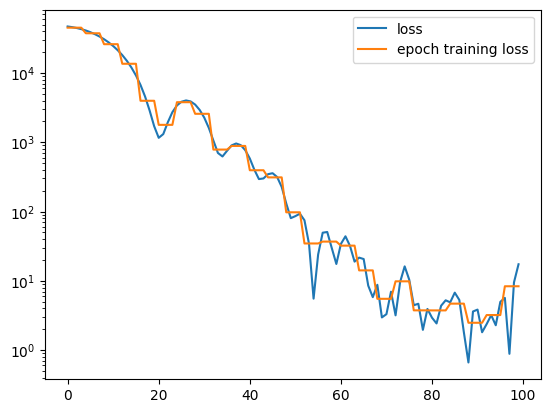

In [28]:
ax = pd.DataFrame(paralogs[0]).plot(y=['loss', 'epoch training loss'])
ax.set_yscale('log')

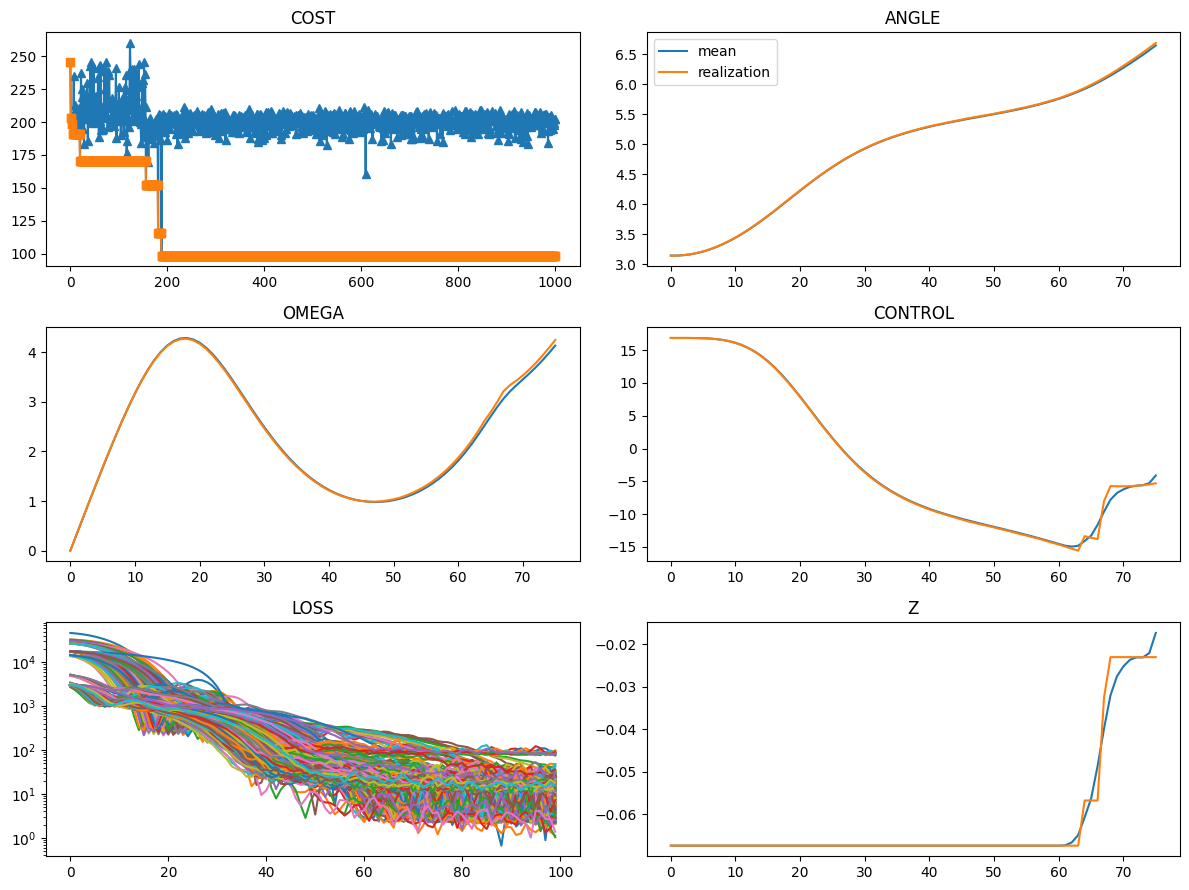

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
axes = axes.flatten()

# cost
real_cost = [expI_cost_logs[0][0]['cost']]
for p in expI_cost_logs[0][1:]:
    if p['cost'] > real_cost[-1]:
        real_cost.append(real_cost[-1])
    else:
        real_cost.append(p['cost'])
axes[0].plot([p['cost'] for p in expI_cost_logs[0]], marker='^')
axes[0].plot(real_cost, marker='s')
axes[0].set_title('COST')

if hasattr(best_model, 'znet'):
    t, x, u, g, r, dw = sde.sample_data(batch_num=128, ctrl=lambda t, x:sde.mu(t, x, best_model.znet(t, x)))
else:
    t, x, u, g, r, dw = sde.sample_data(batch_num=128, ctrl=lambda t, x:sde.mu(t, x, best_model.ynet.get_derivative(t, x)*sde.sigma_0))

# angle
axes[1].plot(x.detach().cpu()[:, :, 0].mean(dim=1), label='mean')
axes[1].plot(x.detach().cpu()[:, 0, 0], label='realization')
axes[1].set_title('ANGLE')
axes[1].legend()

# angular velocity
axes[2].plot(x.detach().cpu()[:, :, 1].mean(dim=-1))
axes[2].plot(x.detach().cpu()[:, 0, 1])
axes[2].set_title('OMEGA')

# control
axes[3].plot(u.detach().cpu()[:, :, 0].mean(dim=1))
axes[3].plot(u.detach().cpu()[:, 0, 0])
axes[3].set_title('CONTROL')

# loss
for it, paralog in enumerate(paralogs):
    axes[4].plot([p['loss'] for p in paralog], label=it)
axes[4].set_yscale('log')
# axes[4].legend()
axes[4].set_title('LOSS')

# Z
if hasattr(best_model, 'znet'):
    z = best_model.znet(t, x)
else:
    z = best_model.ynet.get_derivative(t, x)*sde.sigma_0

axes[5].plot(z.detach().cpu()[:, :, -1].mean(dim=1))
axes[5].plot(z.detach().cpu()[:, 0, -1])
axes[5].set_title('Z')

fig.tight_layout()

In [30]:
[expI_cost_logs[0][0]['cost']] + [min(p['cost'] for p in expI_cost_logs[0][1+i*D['inner_iter']:1+(i+1)*D['inner_iter']]) 
 for i in range(D['max_iteration'])]

[246.01018749507156,
 203.02480149357282,
 204.39207047497905,
 198.5625002571108,
 204.51123374014503,
 190.62528145613754,
 201.10447565696668,
 234.79348287134832,
 195.20186881738206,
 206.7153233145427,
 212.75828528890577,
 201.99836434416576,
 192.51485861082068,
 203.26350293843484,
 197.6482937613316,
 197.44397114979213,
 200.93682663578053,
 191.2094101767698,
 210.53023646672,
 197.85367656598032,
 170.32313294602602,
 203.37043183719237,
 237.46527309300492,
 209.4466829188705,
 224.98617415788206,
 218.7546363692738,
 206.94048652723797,
 194.7239006253216,
 183.6923209214059,
 202.70178440292162,
 220.65425763813786,
 212.48809560068221,
 213.6024007356536,
 218.12028722429073,
 208.7521947741518,
 229.87646128461463,
 185.70321308013726,
 206.52946277828178,
 219.64426584252732,
 208.66499032644083,
 214.77752148907135,
 242.58638477296233,
 200.6819053858547,
 245.75975470622086,
 233.4937436716455,
 200.84639937524742,
 205.60826579076172,
 199.64100178382432,
 241.21

In [31]:
r[0].mean()

tensor(98.2613, device='cuda:0', dtype=torch.float64)

# Save plots

In [32]:
# save cost dataframe
cost_df = pd.DataFrame(expI_cost_logs[0])
cost_df.to_csv(os.path.join(LOGROOTDIR, cost_df.iloc[0]['LossNum']+'.csv'), index=False)

In [33]:
# save trajectories
traj = {
    't': t, 'x': x, 'u': u,
    'g': g, 'r': r, 'dw': dw,
}

for key in traj:
    # move to cpu
    traj[key] = traj[key].detach().cpu()

torch.save(traj, os.path.join(LOGROOTDIR, cost_df.iloc[0]['LossNum']+'.pt'))